Source: https://github.com/eng-amrahmed/vanilla-gan-tf2/blob/master/vanilla-gan-tf2.ipynb

In [25]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

### Create 'gan_samples' folder which will contain all images samples collected during the training
### e.g 1000.png => batch of images samples generated by the generator after 1000 iterations

### Parameters constants

In [26]:
seed          = 2021
batch_size    = 64
iterations    = 2000
lr            = 1e-4
Z_dim         = 100

### We want the results to be reproducible :-) 

In [27]:
np.random.seed(seed)
tf.random.set_seed(seed)

### Uniform distribution data set

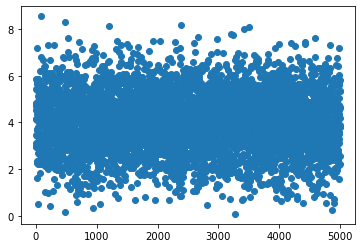

(5000, 1)

In [28]:
N = 5000
x_train = np.random.normal(4,1.25,size = (5000,1))

#x_train = np.random.uniform(size = (5000,1) )
plt.scatter(range(N), x_train)
plt.show()
x_train.shape

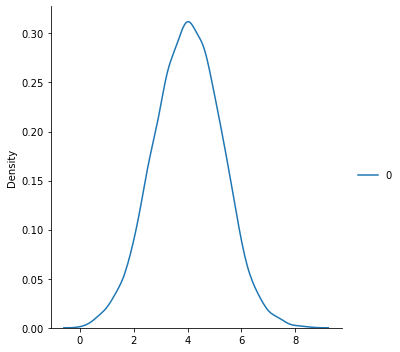

In [29]:
sns.displot(x_train, kind="kde")
plt.show()

### (1) The discriminator network
 It's just a simple MLP network with 1 hidden layers
It returns the probability that the input value is between 0 and 1

In [30]:
class Discriminator(tf.keras.layers.Layer):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear_1 = layers.Dense(5)
        self.linear_2 = layers.Dense(1)
            
    def call(self, x):
        x = self.linear_1(x)
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, 0.2)
        x = self.linear_2(x)
        x = tf.nn.sigmoid(x)        
        return x

### (2) The generator network
It's just a simple MLP network with 1 hidden layers
It return the generated image that is hopefully similar to the samples in uniform distribution after training.

In [31]:
class Generator(tf.keras.layers.Layer):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear_1 = layers.Dense(5)
        self.linear_2 = layers.Dense(1)
            
    def call(self, x):
        x = self.linear_1(x)
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, 0.2)
        x = self.linear_2(x)
        x = tf.nn.sigmoid(x)        
        return x

### Function that used to generate a batch of noise samples to feed to the generator

In [32]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

### During the GAN training we want to observe the GAN quality

In [33]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    plt.plot(samples)
    return fig

### Models and optimizer instantiation

In [34]:
generator     = Generator()
discriminator = Discriminator()
optimizer = tf.optimizers.Adam(lr)

### Here we go ;-)
### See the comments


In [37]:
D_losses = []
G_losses = []

# Start of the training loop
for it in range(iterations):
    
    # ------------------------------------------------------------------------------------
    # Every 1000 iteration we save some samples from the generator to show how it performs
    # during the training.
    # ------------------------------------------------------------------------------------
    if it % 500 == 0:
        samples = generator(sample_Z(16, Z_dim))
        samples = generator(sample_Z(16, Z_dim))
        sns.displot(samples.numpy(), kind="kde")
        #plt.savefig('gan_samples/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
        #plt.close(fig)
   
    # ------------------------------------------------------------------------------------
    # Sample batch of the training examples
    # ------------------------------------------------------------------------------------    
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    Real_sample = x_train[idx]
    
    # ====================================================================================
    # The first step is to train the discriminator
    # --------------------------------------------
    # Note: Please don't forget that the output of the discriminator is the probability of
    #       the given input image is real image (drawn from the training set).
    # We want to train the discriminator to
    #
    # 1- Maximize the probability of assigning the correct label to the training examples " Max. log(D(x)) )  "
    # 2- Minimize the probability of assigning the correct label to the fake examples     " Min. log(D(G(Z))) "
    #
    # We could do that by maximize 
    
    #                               log(D(x))+(1-log(D(G(Z))))
    #
    # Here we take the gradient of the objective function with respect to the 
    # discriminator parameters
    # ------------------------------------------------------------------------------------        
    # Here we take the gradient of the objective function with respect to the 
    # discriminator parameters
    with tf.GradientTape() as tape:  
        Z           = sample_Z(batch_size, Z_dim)
        Fake_sample = generator(Z)
        D_real_prob = discriminator(Real_sample)
        D_fake_prob = discriminator(Fake_sample)
        
        # The negative sign in the front of D_loss below because 
        # the tensorflow optimizer minimize the objective function 
        # and we want to maximize the objective function
    
        D_loss      = -tf.reduce_mean(tf.math.log(D_real_prob) + tf.math.log(1. - D_fake_prob))

        gradients = tape.gradient(D_loss, discriminator.trainable_weights)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))

    # ====================================================================================
    # The second step is to train the generator
    # -----------------------------------------
    # The generator tries to fool the discriminator and make the discriminator to predict 
    # the fake image G(Z) as a real image , in other words try to 
    # 
    #                              maximize log(D(G(Z)))
    #
    #
    # Here we take the gradient of the objective function with respect to the 
    # generator parameters
    # ------------------------------------------------------------------------------------        
    with tf.GradientTape() as tape:        
        Z           = sample_Z(batch_size, Z_dim)
        Fake_sample = generator(Z)
        D_fake_prob = discriminator(Fake_sample)
        
        G_loss   = -tf.reduce_mean(tf.math.log(D_fake_prob))
                
        gradients = tape.gradient(G_loss, generator.trainable_weights)
    optimizer.apply_gradients(zip(gradients, generator.trainable_weights))
    
    # ------------------------------------------------------------------------------------
    # Evaluate the training process by printing both of the discriminator and the 
    # generator losses every 1000 iterations
    # ------------------------------------------------------------------------------------
    if it % 1000 == 0:
        print('Iter: {}     D_loss: {:.4f}     G_loss: {:.4f}'.format(it, D_loss, G_loss))

    # ------------------------------------------------------------------------------------
    # Save the current iteration losses to plot them later at the end of training session
    # ------------------------------------------------------------------------------------
    D_losses.append(D_loss)
    G_losses.append(G_loss)
        

InvalidArgumentError: Matrix size-incompatible: In[0]: [5000,1], In[1]: [100,5] [Op:MatMul]

### Plot both of the discriminator and the generator losses 

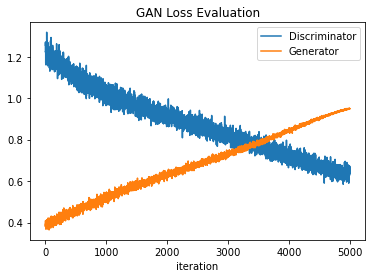

In [36]:
plt.plot(D_losses)
plt.plot(G_losses)
plt.title('GAN Loss Evaluation')
plt.ylabel('')
plt.xlabel('iteration')
plt.legend(['Discriminator', 'Generator'],loc='upper right')
plt.show()